In [41]:
import tensorflow as tf
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


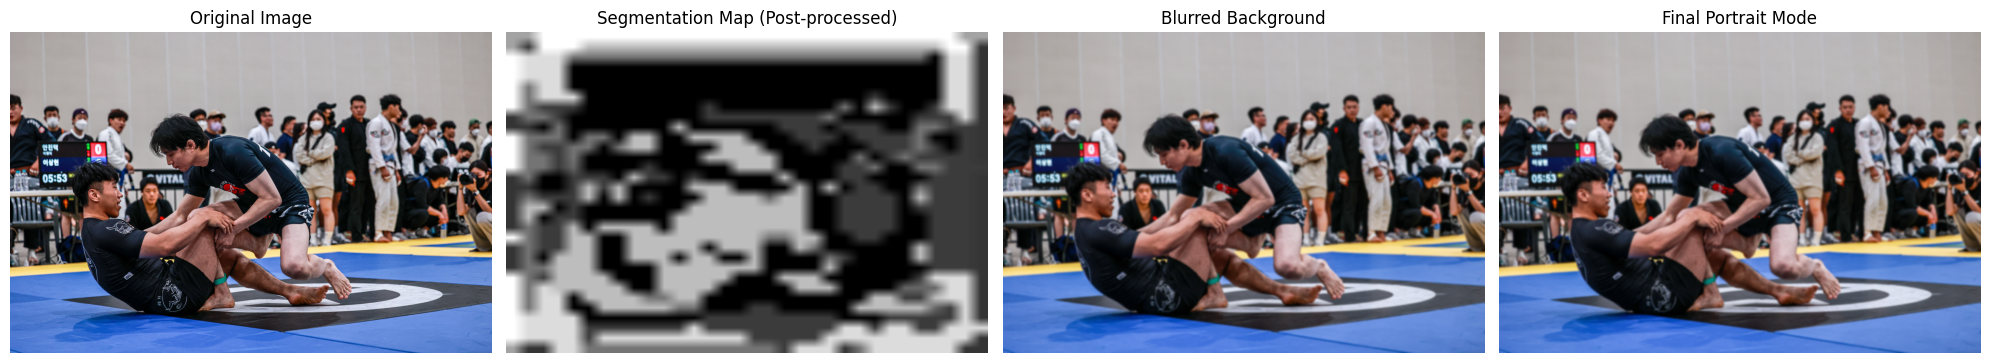

image.jpg 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_deeplabv3\portrait_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


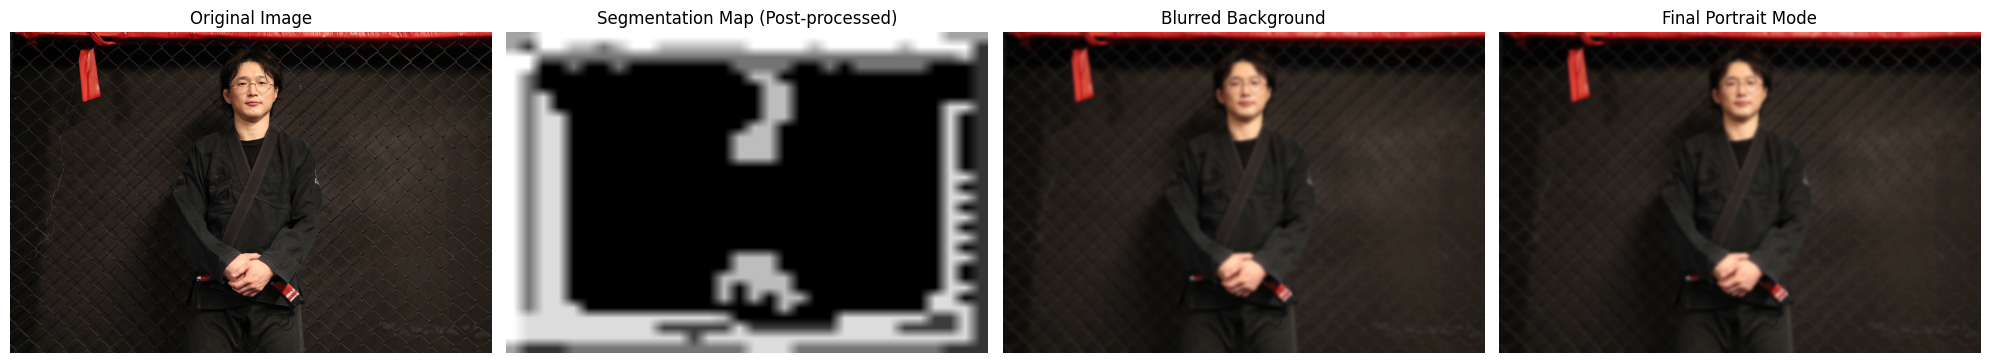

image1.JPG 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_deeplabv3\portrait_image1.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


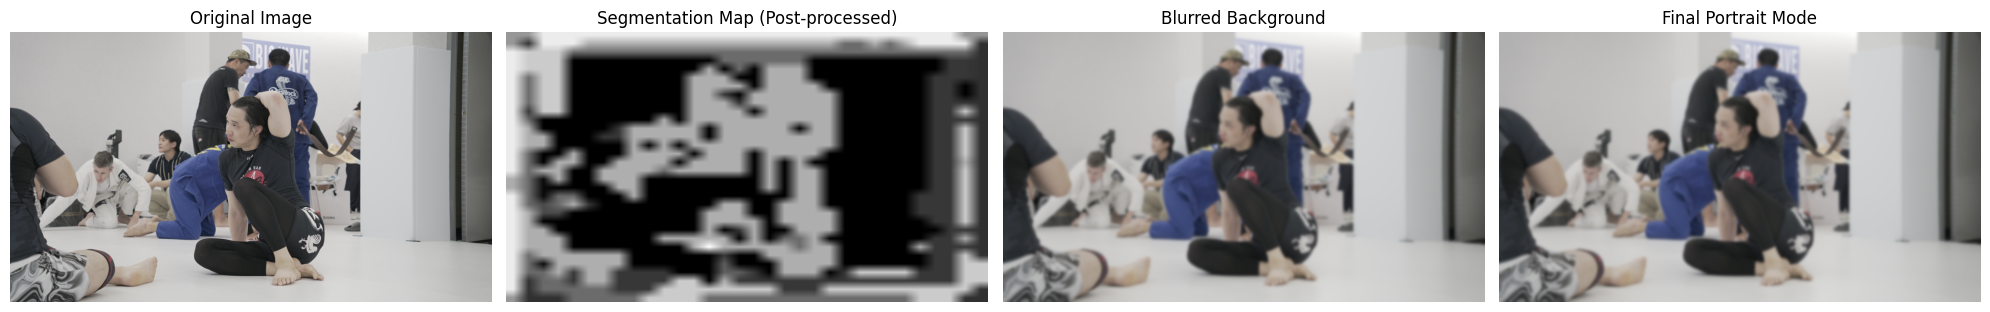

image2.JPG 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_deeplabv3\portrait_image2.JPG
모든 이미지 처리가 완료되었습니다.


In [47]:
# DeepLabV3+ 모델 로드 (ResNet-101 백본 사용, 입력 크기 변경)
model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(1024, 1024, 3))

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_deeplabv3'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    original_size = (image.shape[1], image.shape[0])
    input_image = cv2.resize(image, (1024, 1024))  # 더 큰 해상도로 변경
    input_image = np.expand_dims(input_image, axis=0)
    input_image = tf.cast(input_image, tf.float32) / 127.5 - 1

    # 모델 예측
    predictions = model.predict(input_image)
    segmentation_map = np.argmax(predictions, axis=-1)[0]

    # 원본 크기로 세그멘테이션 맵 리사이즈
    segmentation_map = cv2.resize(segmentation_map.astype(np.uint8), original_size)

    # 모폴로지 연산 적용 (팽창 후 침식으로 인물 영역 확실히)
    kernel = np.ones((5, 5), np.uint8)
    segmentation_map = cv2.morphologyEx(segmentation_map, cv2.MORPH_CLOSE, kernel)

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 마스크를 사용하여 인물만 남기기
    # 세그멘테이션 맵에서 인물로 인식된 부분을 남김 (segmentation_map == 사람의 클래스 번호)
    condition = segmentation_map == 15  # 클래스 15가 인물을 나타낸다고 가정

    # 3채널 마스크 생성 (True는 인물, False는 배경)
    mask = np.stack([condition] * 3, axis=-1)

    # 최종 결과 이미지 생성 (인물은 원본, 배경은 흐림 처리된 이미지)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(segmentation_map, cmap='gray')
    axes[1].set_title("Segmentation Map (Post-processed)")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(blurred_bg, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Blurred Background")
    axes[2].axis('off')

    axes[3].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[3].set_title("Final Portrait Mode")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")

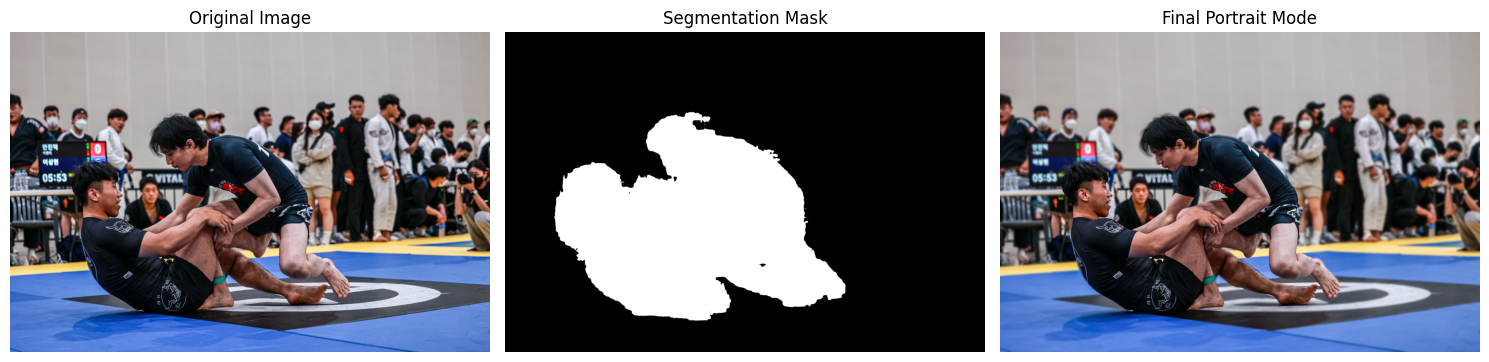

image.jpg 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_mediapipe\portrait_image.jpg


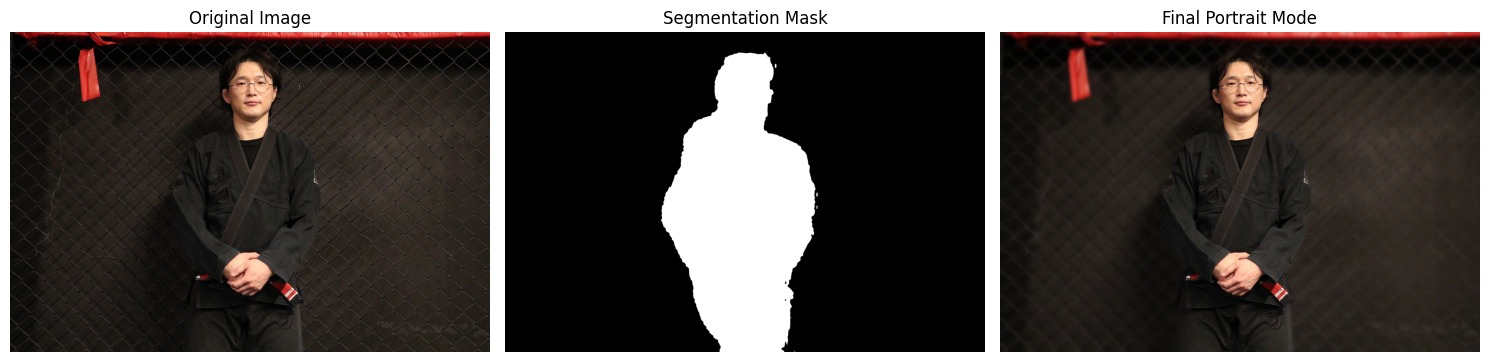

image1.JPG 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_mediapipe\portrait_image1.JPG


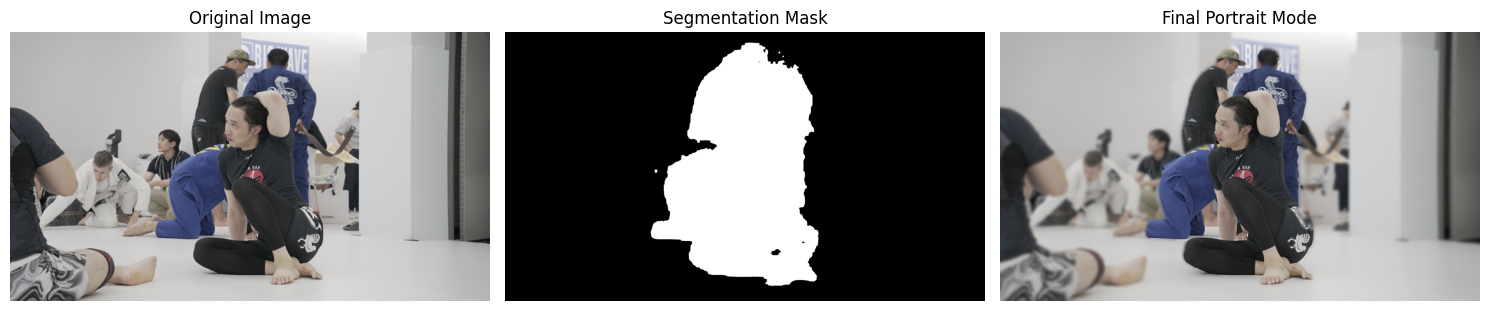

image2.JPG 처리가 완료되었습니다. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_mediapipe\portrait_image2.JPG
모든 이미지 처리가 완료되었습니다.


In [48]:
import mediapipe as mp

# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_mediapipe'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # Selfie Segmentation 적용
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 추출 및 적용
    mask = results.segmentation_mask > 0.5
    mask = np.stack([mask] * 3, axis=-1)  # 3채널 마스크 생성

    # 배경 흐림 처리
    blurred_bg = cv2.GaussianBlur(image, (55, 55), 0)

    # 최종 이미지 생성 (인물은 원본, 배경은 흐림)
    output_image = np.where(mask, image, blurred_bg)

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    axes[1].imshow(mask[:, :, 0], cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Final Portrait Mode")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    output_path = os.path.join(output_folder, f"portrait_{image_name}")
    cv2.imwrite(output_path, output_image)
    print(f"{image_name} 처리가 완료되었습니다. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")


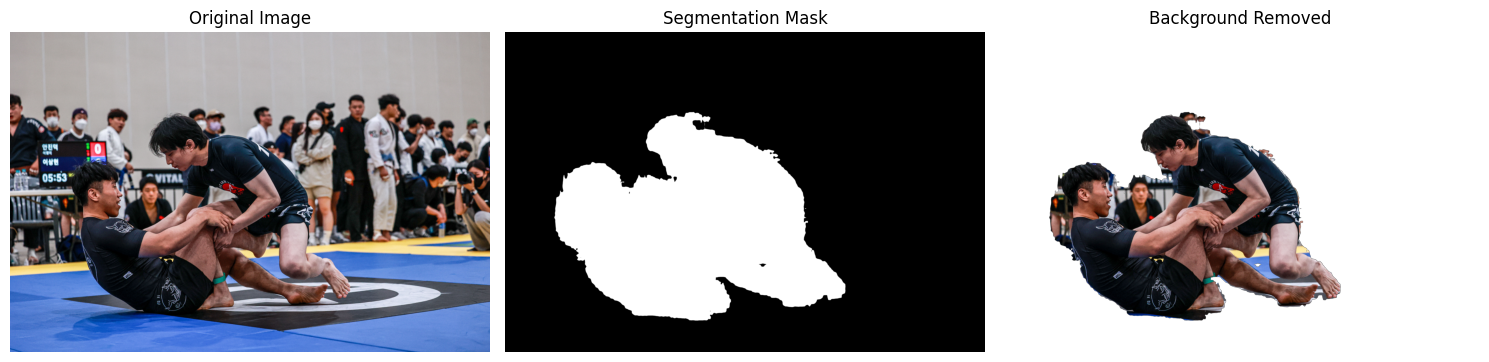

image.jpg 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_only_one\background_removed_image.png


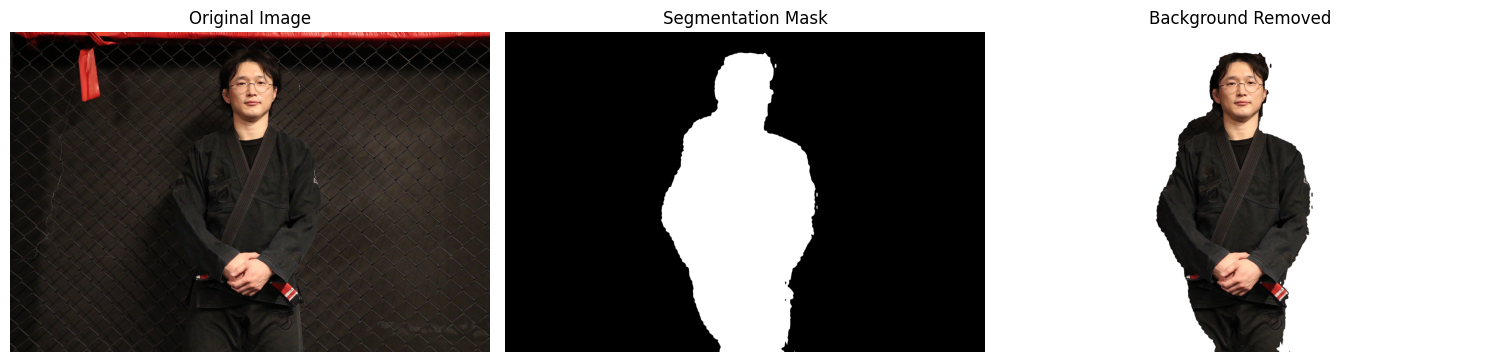

image1.JPG 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_only_one\background_removed_image1.png


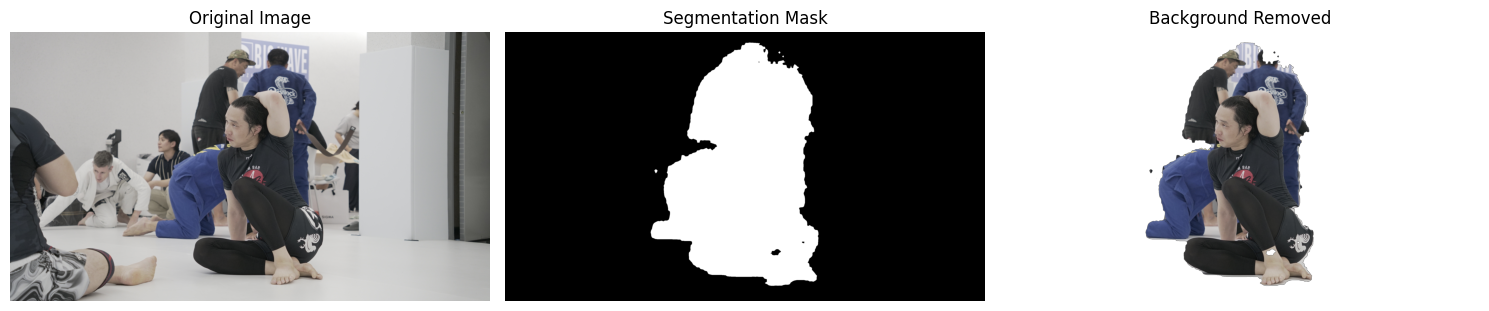

image2.JPG 배경 제거 완료. 결과 저장: C:/Users/envym/workplace/shallo_photo/output_only_one\background_removed_image2.png
모든 이미지 처리가 완료되었습니다.


In [49]:
# MediaPipe Selfie Segmentation 초기화
mp_selfie_segmentation = mp.solutions.selfie_segmentation
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_only_one'

# 출력 폴더가 존재하지 않으면 생성
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"이미지 {image_name}를 읽을 수 없습니다. 건너뜁니다.")
        continue

    # Selfie Segmentation 적용
    results = selfie_segmentation.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # 세그멘테이션 마스크 생성
    mask = results.segmentation_mask > 0.5  # True/False로 구성된 마스크
    mask = mask.astype(np.uint8) * 255      # 0 또는 255로 변환 (OpenCV에서 사용하기 위함)
    
    # 인물만 남기기 (배경을 제거하여 투명하게)
    foreground = cv2.bitwise_and(image, image, mask=mask)

    # 투명 배경을 만들기 위해 4채널 이미지 생성 (RGBA)
    bgra_image = cv2.cvtColor(foreground, cv2.COLOR_BGR2BGRA)

    # 투명도를 위해 알파 채널 추가
    alpha_channel = mask
    bgra_image[:, :, 3] = alpha_channel

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # 원본 이미지
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # 세그멘테이션 마스크
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    # 배경 제거 결과
    axes[2].imshow(cv2.cvtColor(bgra_image, cv2.COLOR_BGRA2RGBA))
    axes[2].set_title("Background Removed")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 저장 (PNG 형식으로 저장해 투명 배경 유지)
    output_path = os.path.join(output_folder, f"background_removed_{image_name.split('.')[0]}.png")
    cv2.imwrite(output_path, bgra_image)
    print(f"{image_name} 배경 제거 완료. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")


In [54]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# U²-Net 모델 로드
from u2net_human_seg_test import U2NET  # U²-Net 모델을 u2net.py로부터 가져옴 (GitHub에서 제공됨)

# 모델 경로 설정 및 로드
model_path = "C:/Users/envym/workplace/shallo_photo/u2net.pth"
net = U2NET(3, 1)
net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
net.eval()  # 평가 모드로 설정

# 이미지 경로 설정
image_folder = 'C:/Users/envym/workplace/shallo_photo/images'
output_folder = 'C:/Users/envym/workplace/shallo_photo/output_u2'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 이미지 파일 처리
for image_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, image_name)

    # 이미지 읽기 및 전처리
    image = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((320, 320)),
                                    transforms.ToTensor()])
    input_image = transform(image).unsqueeze(0)

    # 모델 예측
    with torch.no_grad():
        d1 = net(input_image)
        prediction = d1[:, 0, :, :]
        prediction = F.upsample(prediction.unsqueeze(0), size=image.size[::-1], mode='bilinear')
        prediction = prediction.squeeze().cpu().numpy()

    # 세그멘테이션 마스크 생성 (0 ~ 255)
    mask = (prediction * 255).astype(np.uint8)
    mask = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY)[1]  # 이진화 처리

    # 인물만 남기기 (배경을 투명하게 제거)
    image_np = np.array(image)
    foreground = cv2.bitwise_and(image_np, image_np, mask=mask)

    # 투명 배경을 만들기 위해 4채널 이미지 생성 (RGBA)
    bgra_image = cv2.cvtColor(foreground, cv2.COLOR_RGB2BGRA)
    alpha_channel = mask
    bgra_image[:, :, 3] = alpha_channel

    # 시각적 비교
    fig, axes = plt.subplots(1, 3, figsize=(15, 10))

    # 원본 이미지
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # 세그멘테이션 마스크
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    # 배경 제거 결과
    axes[2].imshow(cv2.cvtColor(bgra_image, cv2.COLOR_BGRA2RGBA))
    axes[2].set_title("Background Removed")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    # 결과 저장 (PNG 형식으로 저장해 투명 배경 유지)
    output_path = os.path.join(output_folder, f"background_removed_{image_name.split('.')[0]}.png")
    cv2.imwrite(output_path, bgra_image)
    print(f"{image_name} 배경 제거 완료. 결과 저장: {output_path}")

print("모든 이미지 처리가 완료되었습니다.")


ModuleNotFoundError: No module named 'model'